In [1]:
import pandas as pd 
import torch 
import monai
import os
import pickle

In [2]:
# path = "/data/kaplinsp/models/log_DenseNet121_2025-04-04_19.59.46.log-fixed-size-1/"
# path = "/data/kaplinsp/models/log_DenseNet121_2025-04-06_02.56.22.log-fixed-size-cropped-64-uniform-thickness-lr0001-0/"
# path = "/data/kaplinsp/models/log_DenseNet121_2025-04-06_22.07.37.log-dilated-cropped-64-uniform-thickness-lr0001-1/"
# path = "/data/kaplinsp/models/log_DenseNet121_2025-04-10_19.17.04.log-fixed-nocrop-65-uniform-thickness-0/"
path = "/data/kaplinsp/models/log_DenseNet121_2025-04-14_01.25.21.log-fixedsize-resample-combineddataset-2/"
model = monai.networks.nets.densenet121(
                dropout_prob=0.4, spatial_dims=3, in_channels=1, out_channels=2
            )
model = model.to(0)

In [3]:
model.load_state_dict(torch.load(os.path.join(path, "best_loss_model.pth"))["model_state_dict"])

/tmp/ipykernel_1190677/2537844734.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(path, "best_loss_model.pth"))["model_stat

<All keys matched successfully>

In [4]:
from datasets import getNoduleInfoList
with open(os.path.join(path, "val.pkl"), 'rb') as f:
    val_ids = pickle.load(f)
nodules = getNoduleInfoList(['sclc'])
nodules = [nod for nod in nodules if (nod.file_path, nod.center_lps) in val_ids]
print(len(nodules))

26


In [5]:
from datasets import NoduleDataset
dataset = NoduleDataset(nodules, 
            isValSet_bool=True,
            dilate=20,
            resample=[64, 64, 64],
            box_size=[65, 65, 80],
            fixed_size=True
            )

from torch.utils.data import DataLoader
val_dl = DataLoader(
            dataset,
            batch_size=16,
            num_workers=4,
            pin_memory=True,
            drop_last=False,
            shuffle=True,
        )

2025-04-14 14:05:04,761 INFO     pid:1190677 datasets:202:__init__ <datasets.NoduleDataset object at 0x7f5492169510>: 26 validation samples


In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you already have a model and a dataloader
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(0)
        labels = labels.to(0)

        outputs = model(inputs)  # Shape: (batch_size, num_classes) or (batch_size,)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # For binary classification
        # If you're using nn.Sigmoid as the final layer, you don't need to apply it again

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Concatenate all batches
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

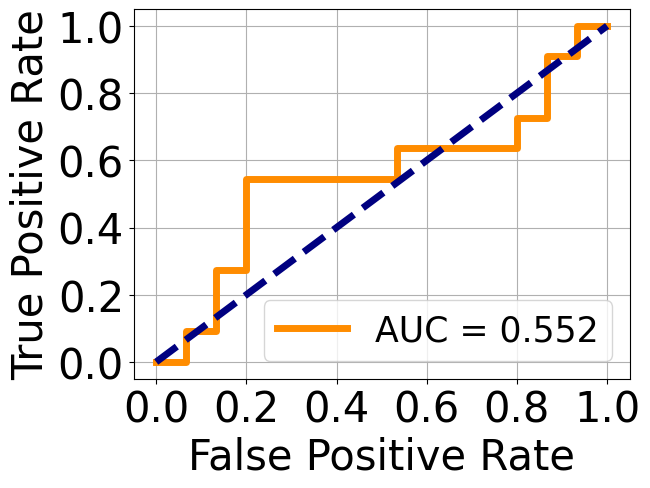

In [7]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=5, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
plt.xlabel('False Positive Rate', fontdict={"size": 30})
plt.ylabel('True Positive Rate',fontdict={"size": 30})
plt.legend(loc="lower right", fontsize=25)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(True)
plt.show()

In [8]:
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# 2. Find the optimal threshold (closest to point (0,1))
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")

# Binarize predictions at the optimal threshold
binary_preds = (all_probs >= optimal_threshold).astype(int)

# Compute metrics
precision = precision_score(all_labels, binary_preds)
recall = recall_score(all_labels, binary_preds)
f1 = f1_score(all_labels, binary_preds)
acc = accuracy_score(all_labels, binary_preds)
specificity = precision_score(all_labels, binary_preds)

print(f"Sensitivity:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Specificity: {precision:.4f}")

Optimal threshold (Youden's J): 0.5447
Sensitivity:    0.5455
F1 Score:  0.6000
Accuracy: 0.6923
Specificity: 0.6667


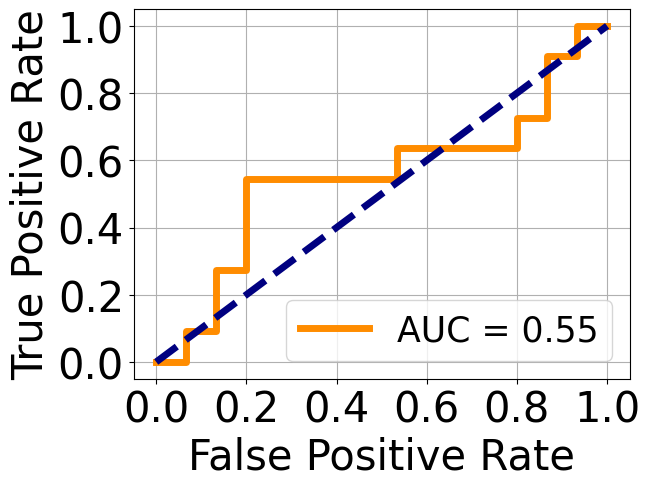

In [9]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=5, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
plt.xlabel('False Positive Rate', fontdict={"size": 30})
plt.ylabel('True Positive Rate',fontdict={"size": 30})
plt.legend(loc="lower right", fontsize=25)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(True)
plt.show()

In [10]:
from image import NoduleInfoTuple, NRRDNodule
coord_file = "/home/kaplinsp/ct_lung_class/annotations-sclc.csv"

exclude_paths = ["/data/kaplinsp/transformation/A114.nrrd"]
coord_df = pd.read_csv(coord_file, index_col=False)

coord_df = coord_df[(coord_df["label"] == 2) & (~coord_df["path"].isin(exclude_paths))]

transformed = list(
    coord_df.apply(
        lambda row: NoduleInfoTuple(
            row["label"],
            row["path"],
            (row["x"], row["y"], row["z"]),
            row["path"],
            NRRDNodule,
        ),
        axis=1,
    ).to_numpy()
)

[NoduleInfoTuple(is_nodule=2, nod_id='/data/kaplinsp/transformation/T462655SB.nrrd', center_lps=(73.54381040198675, -0.8343828483444327, -51.875), file_path='/data/kaplinsp/transformation/T462655SB.nrrd', image_type=<class 'image.NRRDNodule'>),
 NoduleInfoTuple(is_nodule=2, nod_id='/data/kaplinsp/transformation/T462655SB.nrrd', center_lps=(79.71864839933772, 71.49943369205295, -85.625), file_path='/data/kaplinsp/transformation/T462655SB.nrrd', image_type=<class 'image.NRRDNodule'>),
 NoduleInfoTuple(is_nodule=2, nod_id='/data/kaplinsp/transformation/T462655SB.nrrd', center_lps=(107.94647924437083, -22.00525598211925, -126.875), file_path='/data/kaplinsp/transformation/T462655SB.nrrd', image_type=<class 'image.NRRDNodule'>),
 NoduleInfoTuple(is_nodule=2, nod_id='/data/kaplinsp/transformation/T462655SB.nrrd', center_lps=(96.0378631066225, 10.633173432450292, -121.875), file_path='/data/kaplinsp/transformation/T462655SB.nrrd', image_type=<class 'image.NRRDNodule'>),
 NoduleInfoTuple(is_no

In [11]:
from datasets import NoduleDataset
dataset = NoduleDataset(transformed, 
            isValSet_bool=True,
            dilate=20,
            resample=[64, 64, 64],
            box_size=[65, 65, 80],
            fixed_size=True
            )

from torch.utils.data import DataLoader
val_dl = DataLoader(
            dataset,
            batch_size=16,
            num_workers=4,
            pin_memory=True,
            drop_last=False,
            shuffle=True,
        )

2025-04-14 14:05:35,162 INFO     pid:1190677 datasets:202:__init__ <datasets.NoduleDataset object at 0x7f54819060b0>: 18 validation samples


In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you already have a model and a dataloader
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(0)
        labels = torch.ones(inputs.shape[0]).to(0)

        outputs = model(inputs)  # Shape: (batch_size, num_classes) or (batch_size,)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # For binary classification
        # If you're using nn.Sigmoid as the final layer, you don't need to apply it again

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Concatenate all batches
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

/data/kaplinsp/envs/lminfer/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1174: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


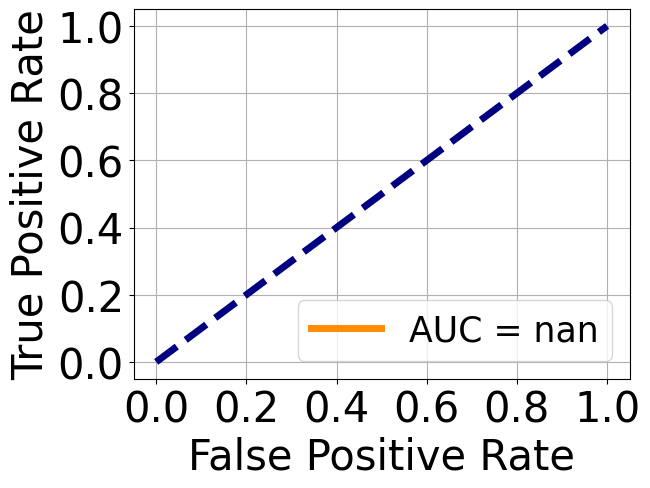

In [58]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=5, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
plt.xlabel('False Positive Rate', fontdict={"size": 30})
plt.ylabel('True Positive Rate',fontdict={"size": 30})
plt.legend(loc="lower right", fontsize=25)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(True)
plt.show()

In [12]:
cutoff = 0.5447  # replace with your actual cutoff
pred_labels = (all_probs >= cutoff).astype(int)
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(all_labels, pred_labels))
print(classification_report(all_labels, pred_labels))

[[12  3]
 [ 5  6]]
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.67      0.55      0.60        11

    accuracy                           0.69        26
   macro avg       0.69      0.67      0.68        26
weighted avg       0.69      0.69      0.69        26



In [37]:
all_probs

array([0.15264763, 0.15202478, 0.14597091, 0.06228953, 0.19322033,
       0.19923164, 0.07629574, 0.24558626, 0.08124487, 0.41956678,
       0.29949504, 0.10220089, 0.22916304, 0.18114053, 0.24580091,
       0.13981824, 0.13616623, 0.27401027], dtype=float32)